In [1]:
import pandas as pd

In [2]:
dr6_splus = pd.read_csv("dr6_list.csv")

In [45]:
#!/usr/bin/env python
import os
import re
import glob
from collections import defaultdict

import numpy as np
import pandas as pd
import healpy as hp
import pyarrow.parquet as pq

from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord, search_around_sky
from astropy.time import Time
from astropy.wcs import WCS
from astropy.nddata import Cutout2D
import astropy.units as u

import gzip
import pyarrow.csv as pa_csv
import pandas as pd
from astropy.table import Table

# -------------------------------------------------
# CONFIG – adjust paths/parameters to your setup
# -------------------------------------------------

SPLUS_BANDS = ["R", "I", "G", "U", "Z", "F378", "F395", "F410",
               "F430", "F515", "F660", "F861"]

# Base dirs where images live; we’ll search in each
SPLUS_IMAGES_PATH = ["/home/astrodados3/splus/idr6/"]

# Cutout configuration
SPLUS_CUTOUT_SIZE = 96  # pixels
# If True, only make S-PLUS cutouts for objects that have a Gaia match
ONLY_GAIA_MATCH_CUTOUTS = True

# Your driver list (one field per line)
DR6_LIST = "dr6_list.csv"   # columns: field, ra, dec  (ra/dec lowercase)

# Pattern for S-PLUS dual catalogs (if ever needed)
SPLUS_CAT_PATTERN = "/home/astrodados3/splus/idr6_final/main/SPLUS-*_dual.fits"

# Gaia DR3 source chunks (GaiaSource_<start>-<end>.csv.gz, HEALPix level-8 ranges)
GAIA_DIR = "/home/astrodados/gaia_dr3"

# Gaia XP spectra chunks (XpContinuousMeanSpectrum_<start>-<end>.csv.gz, same scheme)
GAIA_SPEC_DIR = "/home/astrodados4/downloads/gaia_spectra"

# ZTF HiPS parquet root
ZTF_ROOT = "/home/astrodados3/dados/ztf22/dataset"
# We’ll search over these HiPS orders
ZTF_NORDERS = [2, 3, 4, 5, 6, 7]

# DESI spectra
DESI_ROOT = "/home/astrodados4/downloads/desi_spectra"
DESI_TILES_CSV = "desi_tiles.csv"   # must contain TILEID, TILERA, TILEDEC
DESI_TILE_RADIUS_DEG = 1.7         # match S-PLUS field center to DESI tile center

# APOGEE allStar DR17
APOGEE_PATH = "/home/astrodados4/downloads/allStar-dr17-synspec_rev1.fits"

# spec-z compilation
SPECZ_PATH = "/home/astrodados3/dados/specz_erik/specz_compilation_20250327.parquet"

# VISTA catalog root
VISTA_DIR = "/home/astrodados4/downloads/vista"

# HEALPix schemes for Gaia / Gaia XP
GAIA_NSIDE = 256
GAIA_NEST = True

GAIA_SPEC_NSIDE = GAIA_NSIDE
GAIA_SPEC_NEST = GAIA_NEST

# Matching radii
MATCH_RADIUS_SPLUS_VISTA = 1.0 * u.arcsec
MATCH_RADIUS_SPLUS_GAIA  = 1.2 * u.arcsec
MATCH_RADIUS_SPLUS_ZTF   = 1.0 * u.arcsec
MATCH_RADIUS_SPLUS_DESI  = 1.0 * u.arcsec
MATCH_RADIUS_SPLUS_APOGEE = 1.0 * u.arcsec
MATCH_RADIUS_SPLUS_SPECZ = 1.0 * u.arcsec

# How many S-PLUS rows to process at once (per field)
CHUNK_SIZE = 300000

# -------------------------------------------------
# Small helpers
# -------------------------------------------------

def radec_to_hpix(ra_deg, dec_deg, nside, nest=True):
    ra = np.asarray(ra_deg)
    dec = np.asarray(dec_deg)
    theta = np.radians(90.0 - dec)
    phi = np.radians(ra)
    return hp.ang2pix(nside, theta, phi, nest=nest)

def build_range_index(directory, prefix, suffix):
    """
    Build list of (start, end, path) for files like:
      prefix<start>-<end>suffix

    For Gaia DR3 bulk download, <start>,<end> are HEALPix level-8 indices.
    """
    entries = []
    pattern = re.escape(prefix) + r"(\d+)-(\d+)" + re.escape(suffix)
    for path in glob.glob(os.path.join(directory, prefix + "*" + suffix)):
        fname = os.path.basename(path)
        m = re.search(pattern, fname)
        if not m:
            continue
        start = int(m.group(1))
        end   = int(m.group(2))
        entries.append((start, end, path))
    entries.sort(key=lambda x: x[0])
    return entries

def files_for_hpix_ranges(hpix_indices, range_index):
    """
    Given a list of HEALPix indices and a list of (start,end,path) ranges,
    return the subset of files whose [start,end] overlaps those indices.
    """
    hpix_set = set(int(h) for h in np.unique(hpix_indices))
    files = set()
    for start, end, path in range_index:
        for h in list(hpix_set):
            if start <= h <= end:
                files.add(path)
    return sorted(files)

def ztf_file_for_hpix(hpix, norder, root=ZTF_ROOT):
    """
    hipscat/LSDB-like layout:

      Norder=<norder>/
        Dir=<block_start>/
          Npix=<hpix>.parquet

    where block_start is the start of a 10000-pixel block that contains hpix.
    E.g. hpix=51852 -> Dir=50000
    """
    hpix = int(hpix)
    block_size = 10000
    block_start = (hpix // block_size) * block_size
    directory = f"Dir={block_start}"

    return os.path.join(
        root,
        f"Norder={norder}",
        directory,
        f"Npix={hpix}.parquet",
    )

def desi_file_paths_for_tiles(tile_ids):
    """
    For a list of DESI TILEID values, return all coadd-*.fits files under
    DESI_ROOT/<TILEID>/<NIGHT>/coadd-*-TILEID-thru*.fits (or fallback coadd-*.fits).
    """
    paths = []
    for tileid in tile_ids:
        tileid = int(tileid)
        tile_dir = os.path.join(DESI_ROOT, str(tileid))
        if not os.path.isdir(tile_dir):
            print(f"      [DESI] Tile dir not found for TILEID={tileid}: {tile_dir}")
            continue

        pattern_main = os.path.join(tile_dir, "*", f"coadd-*-{tileid}-thru*.fits")
        tile_paths = glob.glob(pattern_main)
        if not tile_paths:
            # fallback: any coadd file
            pattern_fallback = os.path.join(tile_dir, "*", "coadd-*.fits")
            tile_paths = glob.glob(pattern_fallback)

        tile_paths = sorted(tile_paths)
        if not tile_paths:
            print(f"      [DESI] No coadd files in {tile_dir}")
        else:
            print(f"      [DESI] TILEID {tileid} → {len(tile_paths)} coadd files")
            paths.extend(tile_paths)

    return paths

def match_catalogs(src_coord, cat_coord, max_sep):
    """
    Nearest-neighbour match with rejection beyond max_sep.
    Returns an array of indices into cat_coord (or -1 for no match).
    """
    idx, d2d, _ = src_coord.match_to_catalog_sky(cat_coord)
    idx[d2d > max_sep] = -1
    return idx

def add_gaia_j2000_coords(gaia_cat):
    """
    Add RA/DEC at epoch J2000.0 to a Gaia DR3 chunk, using proper motions.

    - Input columns used (if present): ra, dec, pmra, pmdec
    - Output columns added: ra_j2000, dec_j2000
    - If pm columns are missing or NaN, falls back to original ra/dec.
    """
    required = ["ra", "dec", "pmra", "pmdec"]
    if not all(c in gaia_cat.columns for c in required):
        print("[Gaia] WARNING: Cannot compute J2000 coords (missing pmra/pmdec).")
        return gaia_cat

    ra = gaia_cat["ra"].to_numpy(dtype=float)
    dec = gaia_cat["dec"].to_numpy(dtype=float)
    pmra = gaia_cat["pmra"].to_numpy(dtype=float)   # mas/yr
    pmdec = gaia_cat["pmdec"].to_numpy(dtype=float) # mas/yr

    mask = (
        np.isfinite(ra) &
        np.isfinite(dec) &
        np.isfinite(pmra) &
        np.isfinite(pmdec)
    )
    if not mask.any():
        print("[Gaia] WARNING: No valid rows for J2000 conversion.")
        gaia_cat["ra_j2000"] = gaia_cat["ra"]
        gaia_cat["dec_j2000"] = gaia_cat["dec"]
        return gaia_cat

    # Epoch of Gaia DR3 astrometry
    t_gaia = Time(2016.0, format="decimalyear")
    t_2000 = Time(2000.0, format="decimalyear")

    coord_2016 = SkyCoord(
        ra=ra[mask] * u.deg,
        dec=dec[mask] * u.deg,
        pm_ra_cosdec=pmra[mask] * u.mas/u.yr,
        pm_dec=pmdec[mask] * u.mas/u.yr,
        distance=None,
        obstime=t_gaia,
    )
    coord_2000 = coord_2016.apply_space_motion(new_obstime=t_2000)

    # Default: copy original RA/DEC, then overwrite where valid
    gaia_cat["ra_j2000"] = gaia_cat["ra"]
    gaia_cat["dec_j2000"] = gaia_cat["dec"]

    gaia_cat.loc[mask, "ra_j2000"] = coord_2000.ra.deg
    gaia_cat.loc[mask, "dec_j2000"] = coord_2000.dec.deg

    return gaia_cat

# -------------------------------------------------
# S-PLUS per-field (catalog)
# -------------------------------------------------

def get_splus_path_for_field(field_name):
    """
    Return the S-PLUS dual catalog FITS path for a given field.

    Here we assume files like:
      /home/astrodados3/splus/idr6_final/main/HYDRA-0011_dual.fits
    i.e., <FIELD>_dual.fits
    """
    pattern = os.path.join(
        "/home/astrodados3/splus/idr6_final/main",
        f"{field_name}*.fits"
    )
    print(f"  [SPLUS] Globbing S-PLUS files with pattern: {pattern}")
    candidates = glob.glob(pattern)
    print(f"  [SPLUS] Found {len(candidates)} S-PLUS files for field {field_name}.")
    if len(candidates) == 1:
        return candidates[0]

    raise RuntimeError(
        f"Please define S-PLUS file path for field '{field_name}' "
        f"in get_splus_path_for_field()."
    )

def load_splus_for_field(field_row):
    """
    Open ONLY the S-PLUS catalog corresponding to this field.
    Assumes entire tile is in one FITS file.
    """
    field_name = field_row["field"]
    fits_path = get_splus_path_for_field(field_name)
    print(f"  [SPLUS] Opening S-PLUS file: {fits_path}")
    tab = Table.read(fits_path)
    df = tab.to_pandas()
    if "ra" not in df.columns or "dec" not in df.columns:
        raise ValueError(f"{fits_path} has no 'ra'/'dec' columns.")
    print(f"  [SPLUS] Loaded {len(df)} rows for field {field_name}")
    return df

def read_gaia_ecsv(path):
    """
    Fast ECSV reader for Gaia DR3 (.csv.gz) using pyarrow.
    Safely handles gzip-compressed files and ECSV YAML headers.
    Falls back to astropy on failure.
    """
    print(f"[Gaia/ECSV-fast] {path}")

    # ---- Detect if gzip ----
    is_gzip = path.endswith(".gz")

    # ---- Count header lines (starting with '#') ----
    try:
        if is_gzip:
            f = gzip.open(path, "rt", encoding="utf-8", errors="ignore")
        else:
            f = open(path, "rt", encoding="utf-8", errors="ignore")

        header_lines = 0
        for line in f:
            if line.startswith("#"):
                header_lines += 1
            else:
                break
        f.close()

        # ---- pyarrow read with skip_rows ----
        table = pa_csv.read_csv(
            path,
            read_options=pa_csv.ReadOptions(skip_rows=header_lines),
            convert_options=pa_csv.ConvertOptions(strings_can_be_null=True),
        )

        return table.to_pandas()

    except Exception as e:
        print(f"[Gaia/ECSV-fast] FAILED ({e}), falling back to astropy...")

        # ---- Fallback: safe but slower ----
        tab = Table.read(
            path,
            format="ascii.ecsv",
            guess=False,
            fill_values=[('null', None), ('nan', None)],
        )
        return tab.to_pandas()

# -------------------------------------------------
# S-PLUS image cutouts (stored in parquet)
# -------------------------------------------------

def get_splus_image_path_for_band(field_name, band):
    """
    Find the S-PLUS image file for a given field and band,
    trying all base paths in SPLUS_IMAGES_PATH.
    Expected pattern:
      <base>/<FIELD>/<FIELD>_<BAND>.fits.fz
    Example:
      /home/astrodados3/splus/idr6/HYDRA-0011/HYDRA-0011_F378.fits.fz
    """
    for base in SPLUS_IMAGES_PATH:
        path = os.path.join(base, field_name, f"{field_name}_{band}.fits.fz")
        if os.path.exists(path):
            return path
    raise FileNotFoundError(
        f"No image found for field {field_name}, band {band} "
        f"in any of {SPLUS_IMAGES_PATH}"
    )

def process_chunk_splus_images(field_name,
                               splus_chunk,
                               cutout_size=SPLUS_CUTOUT_SIZE,
                               mask_rows=None):
    """
    For this S-PLUS chunk, generate cutouts in all SPLUS_BANDS and
    return a DataFrame with columns of pixel data:

        splus_cut_R, splus_cut_I, ..., splus_cut_F378, ...

    Each cell is either:
        - a 1D float32 array of length cutout_size*cutout_size,
        - or None if cutout could not be made or was skipped.

    If mask_rows is provided (Series aligned with splus_chunk.index),
    cutouts are generated ONLY for rows where mask_rows is True.
    """
    if splus_chunk.empty:
        return pd.DataFrame(index=splus_chunk.index)

    print(f"      [SPLUS IMG] Making cutouts for chunk with {len(splus_chunk)} rows")

    mask_arr = None
    if mask_rows is not None:
        mask_rows = mask_rows.reindex(splus_chunk.index)
        mask_arr = mask_rows.fillna(False).values

    coords = SkyCoord(
        splus_chunk["ra"].values * u.deg,
        splus_chunk["dec"].values * u.deg,
    )

    result = {f"splus_cut_{b}": [None] * len(splus_chunk) for b in SPLUS_BANDS}

    for band in SPLUS_BANDS:
        col_name = f"splus_cut_{band}"
        try:
            img_path = get_splus_image_path_for_band(field_name, band)
        except FileNotFoundError as e:
            print(f"      [SPLUS IMG] {e}")
            continue

        print(f"      [SPLUS IMG] Using image {img_path} for band {band}")
        try:
            with fits.open(img_path, memmap=True) as hdul:
                if len(hdul) <= 1 or hdul[1].data is None:
                    print(f"      [SPLUS IMG] HDU 1 has no data in {img_path}, skipping band {band}")
                    continue
                image_hdu = hdul[1]
                data = image_hdu.data
                hdr = image_hdu.header
                wcs = WCS(hdr)
        except Exception as e:
            print(f"      [SPLUS IMG] Failed to open {img_path}: {e}")
            continue

        for pos, coord in enumerate(coords):
            if mask_arr is not None and not mask_arr[pos]:
                continue

            try:
                cut = Cutout2D(data, position=coord, wcs=wcs, size=cutout_size)
            except Exception:
                continue

            result[col_name][pos] = cut.data.astype("float32").ravel()

    cutout_df = pd.DataFrame(result, index=splus_chunk.index)
    return cutout_df

# -------------------------------------------------
# Per-chunk external survey processing
#   Gaia / XP / ZTF / DESI / APOGEE / spec-z
# -------------------------------------------------

def process_chunk_gaia(splus_chunk, gaia_index):
    if splus_chunk.empty:
        return pd.DataFrame(index=splus_chunk.index)

    print(f"      [Gaia] Processing chunk with {len(splus_chunk)} S-PLUS rows")

    splus_coord = SkyCoord(
        splus_chunk["ra"].values * u.deg,
        splus_chunk["dec"].values * u.deg,
    )
    hpix_gaia = radec_to_hpix(
        splus_chunk["ra"], splus_chunk["dec"], GAIA_NSIDE, GAIA_NEST
    )

    needed_files = files_for_hpix_ranges(hpix_gaia, gaia_index)
    print(f"      [Gaia] Files needed for this chunk: {len(needed_files)}")
    if not needed_files:
        return pd.DataFrame(index=splus_chunk.index)

    gaia_rows = []
    for path in needed_files:
        df = read_gaia_ecsv(path)
        gaia_rows.append(df)

    gaia_cat = pd.concat(gaia_rows, ignore_index=True)
    print(f"      [Gaia] Total Gaia rows loaded for this chunk: {len(gaia_cat)}")

    # Add J2000 coordinates using proper motions
    gaia_cat = add_gaia_j2000_coords(gaia_cat)

    if "ra_j2000" in gaia_cat.columns and "dec_j2000" in gaia_cat.columns:
        ra_match = gaia_cat["ra_j2000"].values
        dec_match = gaia_cat["dec_j2000"].values
        print("      [Gaia] Using J2000 coords (ra_j2000/dec_j2000) for S-PLUS match.")
    else:
        if "ra" not in gaia_cat.columns or "dec" not in gaia_cat.columns:
            raise ValueError("Gaia catalog has no 'ra'/'dec' columns.")
        ra_match = gaia_cat["ra"].values
        dec_match = gaia_cat["dec"].values
        print("      [Gaia] Falling back to Gaia RA/DEC epoch 2016.0 for match.")

    gaia_coord = SkyCoord(
        ra_match * u.deg,
        dec_match * u.deg,
    )

    match_idx = match_catalogs(splus_coord, gaia_coord, MATCH_RADIUS_SPLUS_GAIA)
    n_matches = np.sum(match_idx != -1)
    print(f"      [Gaia] Matched {n_matches} / {len(splus_chunk)}")

    out = []
    for idx in match_idx:
        out.append({} if idx == -1 else gaia_cat.iloc[int(idx)].to_dict())

    gaia_df = pd.DataFrame(out, index=splus_chunk.index)
    if not gaia_df.empty:
        gaia_df.columns = [f"gaia_{c}" for c in gaia_df.columns]

    return gaia_df

def process_chunk_gaia_spectra(gaia_df, gaia_spec_index):
    """
    Match Gaia XP spectra to the Gaia matches and keep XP 'source_id' so
    it appears as 'gaiaxp_source_id' in the final datacube for QA.
    """
    if gaia_df.empty or "gaia_source_id" not in gaia_df.columns:
        print("      [GaiaXP] No Gaia matches or missing 'gaia_source_id'.")
        return pd.DataFrame(index=gaia_df.index)

    sid_series = gaia_df["gaia_source_id"].dropna()
    if sid_series.empty:
        print("      [GaiaXP] No valid source_ids.")
        return pd.DataFrame(index=gaia_df.index)

    if not {"gaia_ra", "gaia_dec"}.issubset(gaia_df.columns):
        print("      [GaiaXP] Missing 'gaia_ra'/'gaia_dec'.")
        return pd.DataFrame(index=gaia_df.index)

    ra = gaia_df["gaia_ra"].astype(float)
    dec = gaia_df["gaia_dec"].astype(float)
    mask_valid = (~ra.isna()) & (~dec.isna()) & (~gaia_df["gaia_source_id"].isna())
    if not mask_valid.any():
        print("      [GaiaXP] No rows with valid RA/DEC + source_id.")
        return pd.DataFrame(index=gaia_df.index)

    hpix_spec = radec_to_hpix(
        ra[mask_valid].values,
        dec[mask_valid].values,
        GAIA_SPEC_NSIDE,
        GAIA_SPEC_NEST,
    )
    needed_files = files_for_hpix_ranges(hpix_spec, gaia_spec_index)
    print(f"      [GaiaXP] Files needed: {len(needed_files)}")

    if not needed_files:
        return pd.DataFrame(index=gaia_df.index)

    needed_source_ids = set(sid_series.astype("int64").values.tolist())

    spec_rows = []
    for path in needed_files:
        df = read_gaia_ecsv(path)
        if "source_id" not in df.columns:
            print(f"        [GaiaXP] 'source_id' missing in {path}, skipping.")
            continue
        df = df[df["source_id"].isin(needed_source_ids)]
        print(f"        [GaiaXP] {len(df)} rows match in {path}")
        if not df.empty:
            # ensure int64
            df["source_id"] = df["source_id"].astype("int64")
            spec_rows.append(df)

    if not spec_rows:
        print("      [GaiaXP] No XP spectra matched.")
        return pd.DataFrame(index=gaia_df.index)

    spec_cat = pd.concat(spec_rows, ignore_index=True)
    spec_unique = spec_cat.drop_duplicates(subset="source_id", keep="first").copy()
    spec_unique = spec_unique.set_index("source_id")
    spec_unique["source_id"] = spec_unique.index.values

    out = []
    for sid in gaia_df["gaia_source_id"]:
        if pd.isna(sid):
            out.append({})
        else:
            sid_int = int(sid)
            if sid_int in spec_unique.index:
                out.append(spec_unique.loc[sid_int].to_dict())
            else:
                out.append({})

    gaiaxp_df = pd.DataFrame(out, index=gaia_df.index)
    if not gaiaxp_df.empty:
        gaiaxp_df.columns = [f"gaiaxp_{c}" for c in gaiaxp_df.columns]

        if "gaiaxp_source_id" in gaiaxp_df.columns:
            mask_both = (~gaiaxp_df["gaiaxp_source_id"].isna()) & (~gaia_df["gaia_source_id"].isna())
            n_both = mask_both.sum()
            if n_both > 0:
                n_mismatch = (gaiaxp_df["gaiaxp_source_id"][mask_both].astype("int64")
                              != gaia_df["gaia_source_id"][mask_both].astype("int64")).sum()
                print(f"      [GaiaXP] QA: {n_both} rows with both IDs, "
                      f"{n_mismatch} mismatches between gaiaxp_source_id and gaia_source_id")

    return gaiaxp_df

def read_hipscat_parquet_file(path):
    """
    Read a single HiPS/hipscat parquet file without treating directory
    names (e.g. Norder=7) as Hive partitions, to avoid type conflicts
    on columns like 'Norder'.
    """
    pf = pq.ParquetFile(path)
    table = pf.read()   # no dataset partitioning, just the file
    return table.to_pandas()

def process_chunk_ztf(splus_chunk):
    """
    Cross-match this S-PLUS chunk with ZTF HiPS parquet.

    For each S-PLUS object we will store, per filter (g, r, i):

        - full lightcurve arrays: mag, magerr, hmjd
        - total nepochs in that filter

    Final columns (joined on splus_chunk.index):

        ztf_objectid

        ztf_mag_g       (np.ndarray or NaN)
        ztf_magerr_g    (np.ndarray or NaN)
        ztf_hmjd_g      (np.ndarray or NaN)
        ztf_nepochs_g   (int)

        ztf_mag_r, ztf_magerr_r, ztf_hmjd_r, ztf_nepochs_r
        ztf_mag_i, ztf_magerr_i, ztf_hmjd_i, ztf_nepochs_i
    """
    if splus_chunk.empty:
        return pd.DataFrame(index=splus_chunk.index)

    print(f"      [ZTF] Processing chunk with {len(splus_chunk)} S-PLUS rows")
    print(f"      [ZTF] Orders considered: {ZTF_NORDERS}")

    ra_s = splus_chunk["ra"].values
    dec_s = splus_chunk["dec"].values

    print(f"      [ZTF] S-PLUS RA range: {ra_s.min():.3f} .. {ra_s.max():.3f}")
    print(f"      [ZTF] S-PLUS DEC range: {dec_s.min():.3f} .. {dec_s.max():.3f}")

    # -------------------------------------------------
    # 1) Collect all relevant ZTF parquet files
    # -------------------------------------------------
    paths_set = set()
    for norder in ZTF_NORDERS:
        nside = 2 ** norder
        hpix_ztf = radec_to_hpix(ra_s, dec_s, nside, nest=True)
        unique_hpix = np.unique(hpix_ztf)
        print(f"      [ZTF] Norder={norder}, NSIDE={nside}, unique hpix={len(unique_hpix)}")

        for hpix_val in unique_hpix:
            path = ztf_file_for_hpix(hpix_val, norder=norder)
            if os.path.exists(path):
                paths_set.add(path)

    print(f"      [ZTF] Total parquet files found across orders: {len(paths_set)}")

    if not paths_set:
        return pd.DataFrame(index=splus_chunk.index)

    ztf_rows = []
    for path in sorted(paths_set):
        print(f"        [ZTF] Reading {path}")
        tab = read_hipscat_parquet_file(path)
        print(f"        [ZTF]   rows={len(tab)}")
        ztf_rows.append(tab)

    if not ztf_rows:
        return pd.DataFrame(index=splus_chunk.index)

    ztf_cat = pd.concat(ztf_rows, ignore_index=True)
    print(f"      [ZTF] Total ZTF rows loaded: {len(ztf_cat)}")
    print(f"      [ZTF] Columns: {list(ztf_cat.columns)}")

    # -------------------------------------------------
    # 2) Robust column detection and light RA/DEC pre-filter
    # -------------------------------------------------
    ra_col = None
    dec_col = None
    for cand in ("ra", "RA", "Ra", "objra"):
        if cand in ztf_cat.columns:
            ra_col = cand
            break
    for cand in ("dec", "DEC", "Dec", "objdec"):
        if cand in ztf_cat.columns:
            dec_col = cand
            break

    if ra_col is None or dec_col is None:
        raise ValueError("ZTF parquet must contain RA/DEC-like columns (ra/dec or RA/DEC).")

    print(f"      [ZTF] Using RA column '{ra_col}', DEC column '{dec_col}'")

    filter_col = None
    for cand in ("filterid", "filter", "FILTERID", "FILTER"):
        if cand in ztf_cat.columns:
            filter_col = cand
            break
    if filter_col is None:
        raise ValueError("ZTF parquet is missing a filterid column.")

    print(f"      [ZTF] Using filter column '{filter_col}'")

    # Optional: objectid column (for a representative ID)
    objectid_col = None
    for cand in ("objectid", "OBJECTID", "objid"):
        if cand in ztf_cat.columns:
            objectid_col = cand
            break

    # mags, magerrs, times
    mag_col = "mag"
    magerr_col = "magerr"
    hmjd_col = "hmjd"
    for col in (mag_col, magerr_col, hmjd_col):
        if col not in ztf_cat.columns:
            raise ValueError(f"ZTF parquet is missing required column '{col}'")

    print(f"      [ZTF] Using mag columns '{mag_col}', '{magerr_col}' and time column '{hmjd_col}'")
    print(f"      [ZTF] mag dtype (raw): {ztf_cat[mag_col].dtype}")
    print(f"      [ZTF] magerr dtype (raw): {ztf_cat[magerr_col].dtype}")
    print(f"      [ZTF] mag sample (raw):")
    print(ztf_cat[mag_col].head())

    # RA/DEC range of this ZTF subset (for sanity)
    print(f"      [ZTF] ZTF RA range: {ztf_cat[ra_col].min():.3f} .. {ztf_cat[ra_col].max():.3f}")
    print(f"      [ZTF] ZTF DEC range: {ztf_cat[dec_col].min():.3f} .. {ztf_cat[dec_col].max():.3f}")
    print("      [ZTF] filterid value counts:")
    print(ztf_cat[filter_col].value_counts())

    # Small bounding box filter to speed up matching
    pad = MATCH_RADIUS_SPLUS_ZTF.to(u.deg).value * 2.0
    ra_min = ra_s.min() - pad
    ra_max = ra_s.max() + pad
    dec_min = dec_s.min() - pad
    dec_max = dec_s.max() + pad

    mask_box = (
        (ztf_cat[ra_col].values >= ra_min) &
        (ztf_cat[ra_col].values <= ra_max) &
        (ztf_cat[dec_col].values >= dec_min) &
        (ztf_cat[dec_col].values <= dec_max)
    )

    if not mask_box.any():
        print("      [ZTF] After RA/DEC box-cut, no ZTF rows remain.")
        # still return all columns, just NaNs
        out = pd.DataFrame(index=splus_chunk.index)
        out["ztf_objectid"] = np.nan
        for b in ["g", "r", "i"]:
            out[f"ztf_mag_{b}"] = np.nan
            out[f"ztf_magerr_{b}"] = np.nan
            out[f"ztf_hmjd_{b}"] = np.nan
            out[f"ztf_nepochs_{b}"] = 0
        return out

    ztf_cat = ztf_cat.loc[mask_box].reset_index(drop=True)
    print(f"      [ZTF] ZTF rows after RA/DEC box-cut: {len(ztf_cat)}")

    # -------------------------------------------------
    # 3) Build SkyCoord and nearest-neighbour match for a representative objectid
    # -------------------------------------------------
    splus_coord = SkyCoord(ra_s * u.deg, dec_s * u.deg)
    ztf_coord = SkyCoord(
        ztf_cat[ra_col].values * u.deg,
        ztf_cat[dec_col].values * u.deg,
    )

    idx_nearest, sep_nearest, _ = splus_coord.match_to_catalog_sky(ztf_coord)
    mask_nearest = sep_nearest <= MATCH_RADIUS_SPLUS_ZTF
    print(f"      [ZTF] Nearest-neighbour matched {mask_nearest.sum()} / {len(splus_chunk)} S-PLUS objects")
    if mask_nearest.any():
        print(
            "      [ZTF]   sep2d stats (arcsec): "
            f"min={sep_nearest[mask_nearest].min().arcsec:.3f}, "
            f"med={np.median(sep_nearest[mask_nearest].arcsec):.3f}, "
            f"max={sep_nearest[mask_nearest].max().arcsec:.3f}"
        )
    else:
        print("      [ZTF]   no nearest matches within radius")

    ztf_objectid_match = np.full(len(splus_chunk), np.nan)
    if objectid_col is not None:
        obj_arr = ztf_cat[objectid_col].values
        ztf_objectid_match[mask_nearest] = obj_arr[idx_nearest[mask_nearest]]

    # -------------------------------------------------
    # 4) Full light-curves via search_around_sky (all detections within radius)
    # -------------------------------------------------
    idx_splus_all, idx_ztf_all, sep2d_all, _ = search_around_sky(
        splus_coord, ztf_coord, MATCH_RADIUS_SPLUS_ZTF
    )
    print(f"      [ZTF] search_around_sky found {len(idx_splus_all)} S-PLUS–ZTF pairs")

    # Start output DataFrame indexed like splus_chunk and pre-create all columns
    out = pd.DataFrame(index=splus_chunk.index)
    out["ztf_objectid"] = ztf_objectid_match
    for b in ["g", "r", "i"]:
        out[f"ztf_mag_{b}"] = np.nan
        out[f"ztf_magerr_{b}"] = np.nan
        out[f"ztf_hmjd_{b}"] = np.nan
        out[f"ztf_nepochs_{b}"] = 0

    if len(idx_splus_all) == 0:
        # no detailed lightcurves, but objectid_match may exist
        print("      [ZTF] No detailed lightcurves; returning only object IDs.")
        return out

    # Prepare a working DataFrame with one row per SPLUS–ZTF pair
    pairs = pd.DataFrame({
        "i_splus": idx_splus_all.astype(int),
        "i_ztf": idx_ztf_all.astype(int),
    })

    pairs[filter_col] = ztf_cat.iloc[pairs["i_ztf"]][filter_col].to_numpy()
    pairs[mag_col] = ztf_cat.iloc[pairs["i_ztf"]][mag_col].to_numpy()
    pairs[magerr_col] = ztf_cat.iloc[pairs["i_ztf"]][magerr_col].to_numpy()
    pairs[hmjd_col] = ztf_cat.iloc[pairs["i_ztf"]][hmjd_col].to_numpy()
    pairs["nepochs"] = ztf_cat.iloc[pairs["i_ztf"]]["nepochs"].to_numpy()

    if objectid_col is not None:
        pairs[objectid_col] = ztf_cat.iloc[pairs["i_ztf"]][objectid_col].to_numpy()

    # Map filterid -> filter name
    ZTF_FILTER_MAP = {1: "g", 2: "r", 3: "i"}
    pairs["filter_name"] = pairs[filter_col].map(ZTF_FILTER_MAP)

    print(f"      [ZTF] Valid detections for light-curves: {len(pairs)}")
    print("      [ZTF] filter_name counts:")
    print(pairs["filter_name"].value_counts())

    # -------------------------------------------------
    # 5) Helpers to concatenate arrays / sum nepochs
    # -------------------------------------------------
    def concat_arrays(series):
        arrays = []
        for x in series:
            if x is None:
                continue
            if isinstance(x, (list, tuple, np.ndarray)):
                arr = np.asarray(x, dtype=float)
                if arr.size > 0:
                    arrays.append(arr[np.isfinite(arr)])
        if not arrays:
            return np.nan
        return np.concatenate(arrays)

    def sum_nepochs(series):
        vals = pd.to_numeric(series, errors="coerce")
        vals = vals[np.isfinite(vals)]
        if vals.size == 0:
            return 0
        return int(vals.sum())

    # -------------------------------------------------
    # 6) Aggregate per (i_splus, filter_name)
    # -------------------------------------------------
    agg = pairs.groupby(["i_splus", "filter_name"]).agg(
        {
            mag_col: concat_arrays,
            magerr_col: concat_arrays,
            hmjd_col: concat_arrays,
            "nepochs": sum_nepochs,
        }
    ).reset_index()

    # Map from local i_splus (0..len-1) to global index (splus_chunk.index)
    local_to_global = pd.Series(splus_chunk.index.to_numpy(),
                                index=np.arange(len(splus_chunk)))

    bands = ["g", "r", "i"]
    for band in bands:
        band_rows = agg[agg["filter_name"] == band]
        if band_rows.empty:
            continue

        global_index = local_to_global.loc[band_rows["i_splus"].values].values

        mag_series = pd.Series(band_rows[mag_col].values, index=global_index)
        magerr_series = pd.Series(band_rows[magerr_col].values, index=global_index)
        hmjd_series = pd.Series(band_rows[hmjd_col].values, index=global_index)
        ne_series = pd.Series(band_rows["nepochs"].values, index=global_index)

        out.loc[global_index, f"ztf_mag_{band}"] = mag_series
        out.loc[global_index, f"ztf_magerr_{band}"] = magerr_series
        out.loc[global_index, f"ztf_hmjd_{band}"] = hmjd_series
        out.loc[global_index, f"ztf_nepochs_{band}"] = ne_series.fillna(0).astype(int)

        print(
            f"      [ZTF] Band {band}: "
            f"{out[f'ztf_mag_{band}'].notna().sum()} S-PLUS objects with light-curves"
        )

    # -------------------------------------------------
    # 7) Final debug: show some non-null rows
    # -------------------------------------------------
    band_cols = [c for c in ["ztf_mag_g", "ztf_mag_r", "ztf_mag_i"] if c in out.columns]
    if band_cols:
        nn = out[ out[band_cols].notna().any(axis=1) ]
        print("      [ZTF] Example final ZTF rows (non-null mags):")
        print(nn.head())
    else:
        print("      [ZTF] No ZTF mag columns created (this should not happen).")

    return out

def process_chunk_desi(splus_chunk, desi_tile_ids):
    """
    Cross-match this S-PLUS chunk with DESI coadd spectra and store
    BOTH FIBERMAP metadata and full spectra arrays directly in the cube.

    For each matched S-PLUS row, we will store:

        desi_TARGETID, desi_TILEID, ... (from FIBERMAP)

        desi_wave_b  (1D np.ndarray, or NaN)
        desi_flux_b  (1D np.ndarray, or NaN)
        desi_ivar_b  (1D np.ndarray, or NaN)

        desi_wave_r, desi_flux_r, desi_ivar_r
        desi_wave_z, desi_flux_z, desi_ivar_z
    """
    if splus_chunk.empty:
        return pd.DataFrame(index=splus_chunk.index)

    print(f"      [DESI] Processing chunk with {len(splus_chunk)} S-PLUS rows")
    print(f"      [DESI] Tiles considered for this field: {len(desi_tile_ids)}")

    if not desi_tile_ids:
        return pd.DataFrame(index=splus_chunk.index)

    # S-PLUS coordinates
    splus_coord = SkyCoord(
        splus_chunk["ra"].values * u.deg,
        splus_chunk["dec"].values * u.deg,
    )

    # One dict per S-PLUS row; we will fill them as we match fibers
    desi_rows = [ {} for _ in range(len(splus_chunk)) ]

    # Get all coadd files for these tiles
    paths = desi_file_paths_for_tiles(desi_tile_ids)
    print(f"      [DESI] Total DESI coadd files to inspect: {len(paths)}")

    # Helper: get wavelength grid for a given band
    def get_wave(hd, band):
        # Try explicit WAVELENGTH HDU first (preferred in DESI DR1)
        name = f"{band.upper()}_WAVELENGTH"
        if name in hd:
            wave = np.asarray(hd[name].data, dtype="float32")
            return wave

        # Fallback: build from CRVAL1/CDELT1 in the FLUX header
        flux_hdu_name = f"{band.upper()}_FLUX"
        if flux_hdu_name not in hd:
            return None
        h = hd[flux_hdu_name].header
        data = hd[flux_hdu_name].data
        # data shape: (nspec, nwave)
        nwave = data.shape[1]
        crval = h.get("CRVAL1")
        cdelt = h.get("CDELT1")
        if crval is None or cdelt is None:
            return None
        pix = np.arange(nwave, dtype="float32")
        return (crval + cdelt * pix).astype("float32")

    for path in paths:
        print(f"        [DESI] Opening {path}")
        try:
            hd = fits.open(path, memmap=True)
        except Exception as e:
            print(f"        [DESI] Failed to open {path}: {e}")
            continue

        if "FIBERMAP" not in hd:
            print("        [DESI] No FIBERMAP extension, skipping.")
            hd.close()
            continue

        fibermap = Table(hd["FIBERMAP"].data).to_pandas()

        # Make sure we have RA/DEC in the FIBERMAP
        ra_col = None
        dec_col = None
        for cand in ("TARGET_RA", "RA"):
            if cand in fibermap.columns:
                ra_col = cand
                break
        for cand in ("TARGET_DEC", "DEC"):
            if cand in fibermap.columns:
                dec_col = cand
                break

        if ra_col is None or dec_col is None:
            print("        [DESI] FIBERMAP missing TARGET_RA/DEC, skipping.")
            hd.close()
            continue

        fibermap = fibermap.dropna(subset=[ra_col, dec_col])
        if fibermap.empty:
            print("        [DESI] All TARGET_RA/DEC are NaN in this file, skipping.")
            hd.close()
            continue

        desi_coord = SkyCoord(
            fibermap[ra_col].values * u.deg,
            fibermap[dec_col].values * u.deg,
        )

        # Nearest-neighbour match for this coadd file
        match_idx = match_catalogs(splus_coord, desi_coord, MATCH_RADIUS_SPLUS_DESI)
        n_matches = np.sum(match_idx != -1)
        print(f"        [DESI] Matched {n_matches} / {len(splus_chunk)} in this file")

        if n_matches == 0:
            hd.close()
            continue

        # Pre-load spectra arrays per band (if present)
        bands_present = []
        flux_data = {}
        ivar_data = {}
        wave_data = {}

        for band in ("b", "r", "z"):
            flux_hdu_name = f"{band.upper()}_FLUX"
            ivar_hdu_name = f"{band.upper()}_IVAR"

            if flux_hdu_name in hd:
                flux_data[band] = np.asarray(hd[flux_hdu_name].data, dtype="float32")
                if ivar_hdu_name in hd:
                    ivar_data[band] = np.asarray(hd[ivar_hdu_name].data, dtype="float32")
                else:
                    ivar_data[band] = None

                wave = get_wave(hd, band)
                wave_data[band] = wave
                bands_present.append(band)

        print(f"        [DESI] Bands with spectra in this file: {bands_present}")

        # Now, for each S-PLUS row matched to a DESI fiber in this file,
        # attach both the fibermap metadata and spectra arrays.
        for i_splus, idx_fiber in enumerate(match_idx):
            if idx_fiber == -1:
                continue

            # If this S-PLUS row already has a DESI match from a previous file,
            # keep the first one (you can change this if you want multiple tiles).
            if desi_rows[i_splus]:
                continue

            # --- Metadata from fibermap ---
            row = dict(fibermap.iloc[int(idx_fiber)])
            row["desi_file"] = path  # keep which coadd file it came from

            # --- Spectra per band ---
            for band in bands_present:
                flux2d = flux_data[band]
                ivar2d = ivar_data[band]
                wave = wave_data[band]

                # flux2d shape: (nspec, nwave).  Take the row idx_fiber.
                try:
                    flux_1d = flux2d[int(idx_fiber), :].astype("float32")
                except Exception:
                    flux_1d = None

                if ivar2d is not None:
                    try:
                        ivar_1d = ivar2d[int(idx_fiber), :].astype("float32")
                    except Exception:
                        ivar_1d = None
                else:
                    ivar_1d = None

                # Store in row; these names will later get "desi_" prefix
                row[f"wave_{band}"] = wave  # same array for all fibers in this file
                row[f"flux_{band}"] = flux_1d
                row[f"ivar_{band}"] = ivar_1d

            desi_rows[i_splus] = row

        hd.close()

    desi_df = pd.DataFrame(desi_rows, index=splus_chunk.index)

    # Prefix all columns with 'desi_' to avoid collisions
    if not desi_df.empty:
        desi_df.columns = [f"desi_{c}" for c in desi_df.columns]

    return desi_df

def process_chunk_apogee(splus_chunk, apogee_cat, apogee_coord):
    """
    Cross-match this S-PLUS chunk with APOGEE allStar DR17 (single big table).
    """
    if splus_chunk.empty or apogee_cat is None or apogee_coord is None:
        return pd.DataFrame(index=splus_chunk.index)

    print(f"      [APOGEE] Processing chunk with {len(splus_chunk)} S-PLUS rows")

    splus_coord = SkyCoord(
        splus_chunk["ra"].values * u.deg,
        splus_chunk["dec"].values * u.deg,
    )

    match_idx = match_catalogs(splus_coord, apogee_coord, MATCH_RADIUS_SPLUS_APOGEE)
    n_matches = np.sum(match_idx != -1)
    print(f"      [APOGEE] Matched {n_matches} / {len(splus_chunk)}")

    out = []
    for idx in match_idx:
        out.append({} if idx == -1 else apogee_cat.iloc[int(idx)].to_dict())

    apogee_df = pd.DataFrame(out, index=splus_chunk.index)
    if not apogee_df.empty:
        apogee_df.columns = [f"apogee_{c}" for c in apogee_df.columns]

    return apogee_df

def process_chunk_specz(splus_chunk, specz_cat, specz_coord):
    """
    Cross-match this S-PLUS chunk with spec-z compilation (single parquet table).
    """
    if splus_chunk.empty or specz_cat is None or specz_coord is None:
        return pd.DataFrame(index=splus_chunk.index)

    print(f"      [SPECZ] Processing chunk with {len(splus_chunk)} S-PLUS rows")

    splus_coord = SkyCoord(
        splus_chunk["ra"].values * u.deg,
        splus_chunk["dec"].values * u.deg,
    )

    match_idx = match_catalogs(splus_coord, specz_coord, MATCH_RADIUS_SPLUS_SPECZ)
    n_matches = np.sum(match_idx != -1)
    print(f"      [SPECZ] Matched {n_matches} / {len(splus_chunk)}")

    out = []
    for idx in match_idx:
        out.append({} if idx == -1 else specz_cat.iloc[int(idx)].to_dict())

    specz_df = pd.DataFrame(out, index=splus_chunk.index)
    if not specz_df.empty:
        specz_df.columns = [f"specz_{c}" for c in specz_df.columns]

    return specz_df

def load_vista_for_field(field_name):
    """
    Load the VISTA catalog parquet for a given S-PLUS field.

    Expected filename pattern:
      VISTA_DIR/<field_name>*.parquet

    Example:
      /home/astrodados4/downloads/vista/SPLUS-n11s28.parquet
    """
    pattern = os.path.join(VISTA_DIR, f"{field_name}*.parquet")
    print(f"  [VISTA] Globbing VISTA files with pattern: {pattern}")
    candidates = glob.glob(pattern)
    print(f"  [VISTA] Found {len(candidates)} VISTA files for field {field_name}.")

    if not candidates:
        print(f"  [VISTA] No VISTA catalog for field {field_name}")
        return None

    # If there are multiple, just pick the first and warn
    if len(candidates) > 1:
        print(f"  [VISTA] Multiple VISTA files for {field_name}, using first: {candidates[0]}")

    vista_path = candidates[0]
    print(f"  [VISTA] Opening {vista_path}")
    vista_cat = pd.read_parquet(vista_path)

    if "ra2000" not in vista_cat.columns or "dec2000" not in vista_cat.columns:
        raise ValueError(f"VISTA catalog {vista_path} has no 'ra2000'/'dec2000' columns.")

    # Make sure RA/DEC are floats
    vista_cat["ra"] = vista_cat["ra2000"].astype(float)
    vista_cat["dec"] = vista_cat["dec2000"].astype(float)

    print(f"  [VISTA] Loaded {len(vista_cat)} VISTA rows for field {field_name}")
    return vista_cat

def process_chunk_vista(splus_chunk, vista_cat, vista_coord):
    """
    Cross-match this S-PLUS chunk with the per-field VISTA catalog.

    vista_cat: pandas DataFrame with columns 'ra', 'dec' + others
    vista_coord: SkyCoord built from vista_cat['ra'], vista_cat['dec']
    """
    if splus_chunk.empty or vista_cat is None or vista_coord is None:
        return pd.DataFrame(index=splus_chunk.index)

    print(f"      [VISTA] Processing chunk with {len(splus_chunk)} S-PLUS rows")

    splus_coord = SkyCoord(
        splus_chunk["ra"].values * u.deg,
        splus_chunk["dec"].values * u.deg,
    )

    match_idx = match_catalogs(splus_coord, vista_coord, MATCH_RADIUS_SPLUS_VISTA)
    n_matches = np.sum(match_idx != -1)
    print(f"      [VISTA] Matched {n_matches} / {len(splus_chunk)}")

    out = []
    for idx in match_idx:
        out.append({} if idx == -1 else vista_cat.iloc[int(idx)].to_dict())

    vista_df = pd.DataFrame(out, index=splus_chunk.index)
    if not vista_df.empty:
        vista_df.columns = [f"vista_{c}" for c in vista_df.columns]

    return vista_df

# -------------------------------------------------
# Per-field datacube
# -------------------------------------------------

def build_datacube_for_field(field_row,
                             gaia_index,
                             gaia_spec_index,
                             desi_tiles,
                             desi_tiles_coord,
                             apogee_cat,
                             apogee_coord,
                             specz_cat,
                             specz_coord):
    field_name = field_row["field"]
    field_ra = float(field_row["ra"])
    field_dec = float(field_row["dec"])

    print(f"\n=== Field {field_name} ({field_ra}, {field_dec}) ===")

    # 0. Determine DESI tiles near this field (based on field center)
    field_center = SkyCoord(field_ra * u.deg, field_dec * u.deg)
    sep = field_center.separation(desi_tiles_coord)
    mask_tiles = sep.deg < DESI_TILE_RADIUS_DEG
    field_tile_ids = desi_tiles.loc[mask_tiles, "TILEID"].astype(int).tolist()
    print(f"  [DESI] Tiles within {DESI_TILE_RADIUS_DEG} deg of field center: {len(field_tile_ids)}")

    # 1. Open ONLY the S-PLUS catalog for this field
    splus_field = load_splus_for_field(field_row)
    print(f"  [SPLUS] Objects in this field file: {len(splus_field)}")

    # 1b. Load VISTA catalog for this field (if available)
    vista_cat = load_vista_for_field(field_name)
    vista_coord = None
    if vista_cat is not None:
        vista_coord = SkyCoord(
            vista_cat["ra2000"].values * u.deg,
            vista_cat["dec2000"].values * u.deg,
        )

    all_chunks = []

    # 2. Process this field in chunks (for memory)
    for start in range(0, len(splus_field), CHUNK_SIZE):
        end = min(start + CHUNK_SIZE, len(splus_field))
        print(f"    [Field {field_name}] chunk {start}-{end}")
        chunk = splus_field.iloc[start:end].copy()

        # Gaia first (so we can decide which rows get cutouts)
        gaia_df = process_chunk_gaia(chunk, gaia_index)
        if "gaia_source_id" in gaia_df.columns:
            gaia_df["gaia_source_id"] = gaia_df["gaia_source_id"].astype("Int64")

        # Mask for cutouts: only rows with Gaia matches (if enabled)
        cutout_mask = None
        if ONLY_GAIA_MATCH_CUTOUTS and not gaia_df.empty and "gaia_source_id" in gaia_df.columns:
            cutout_mask = ~gaia_df["gaia_source_id"].isna()
            print(f"    [SPLUS IMG] Gaia-matched rows for cutouts: {cutout_mask.sum()} / {len(cutout_mask)}")

        # S-PLUS cutouts stored directly in parquet
        splus_img_df = process_chunk_splus_images(field_name, chunk, mask_rows=cutout_mask)

        # Gaia XP, ZTF, DESI, APOGEE, spec-z, VISTA
        gaiaxp_df = process_chunk_gaia_spectra(gaia_df, gaia_spec_index)
        ztf_df    = process_chunk_ztf(chunk)
        desi_df   = process_chunk_desi(chunk, field_tile_ids)
        apogee_df = process_chunk_apogee(chunk, apogee_cat, apogee_coord)
        specz_df  = process_chunk_specz(chunk, specz_cat, specz_coord)
        vista_df  = process_chunk_vista(chunk, vista_cat, vista_coord)

        # QA: XP IDs
        if not gaiaxp_df.empty and "gaiaxp_source_id" in gaiaxp_df.columns and "gaia_source_id" in gaia_df.columns:
            mask = (~gaiaxp_df["gaiaxp_source_id"].isna()) & (~gaia_df["gaia_source_id"].isna())
            if mask.any():
                same_id = (gaiaxp_df.loc[mask, "gaiaxp_source_id"].astype("int64") ==
                           gaia_df.loc[mask, "gaia_source_id"].astype("int64"))
                print("    [GaiaXP] Fraction of rows with matching IDs:", float(same_id.mean()))

        merged = (chunk
                  .join(splus_img_df)
                  .join(gaia_df)
                  .join(gaiaxp_df)
                  .join(ztf_df)
                  .join(desi_df)
                  .join(apogee_df)
                  .join(specz_df)
                  .join(vista_df))
        all_chunks.append(merged)

    datacube_field = pd.concat(all_chunks, ignore_index=True)
    out_name = f"datacube_{field_name}.parquet"
    datacube_field.to_parquet(out_name)
    print(f"  [OUT] Saved {len(datacube_field)} rows to {out_name}")

    del datacube_field
    del all_chunks
    del splus_field

# -------------------------------------------------
# Main
# -------------------------------------------------

def main():
    # Driver list
    dr6_splus = pd.read_csv(DR6_LIST)
    dr6_splus = dr6_splus[dr6_splus['field'] == 'STRIPE82-0001']
    print(f"Loaded {len(dr6_splus)} rows from {DR6_LIST}")

    # Gaia indices
    gaia_index = build_range_index(GAIA_DIR, "GaiaSource_", ".csv.gz")
    print(f"Indexed {len(gaia_index)} Gaia source chunks")

    gaia_spec_index = build_range_index(
        GAIA_SPEC_DIR, "XpContinuousMeanSpectrum_", ".csv.gz"
    )
    print(f"Indexed {len(gaia_spec_index)} Gaia XP spectra chunks")

    # DESI tiles
    desi_tiles = pd.read_csv(DESI_TILES_CSV)
    for col in ("TILEID", "TILERA", "TILEDEC"):
        if col not in desi_tiles.columns:
            raise ValueError(f"{DESI_TILES_CSV} is missing '{col}' column.")
    print(f"Loaded {len(desi_tiles)} DESI tiles from {DESI_TILES_CSV}")

    desi_tiles_coord = SkyCoord(
        desi_tiles["TILERA"].values * u.deg,
        desi_tiles["TILEDEC"].values * u.deg,
    )

    # APOGEE allStar DR17
    apogee_cat = None
    apogee_coord = None
    if os.path.exists(APOGEE_PATH):
        print(f"Loading APOGEE catalog from {APOGEE_PATH}")
        tab = Table.read(APOGEE_PATH)

        names_1d = [name for name in tab.colnames if tab[name].ndim <= 1]
        tab_1d = tab[names_1d]

        apogee_cat = tab_1d.to_pandas()

        if "RA" not in apogee_cat.columns or "DEC" not in apogee_cat.columns:
            raise ValueError("APOGEE catalog has no 'RA'/'DEC' columns.")

        mask = (~apogee_cat["RA"].isna()) & (~apogee_cat["DEC"].isna())
        apogee_cat = apogee_cat.loc[mask].reset_index(drop=True)
        apogee_coord = SkyCoord(
            apogee_cat["RA"].values * u.deg,
            apogee_cat["DEC"].values * u.deg,
        )
        print(f"Loaded {len(apogee_cat)} APOGEE rows with valid RA/DEC and 1D columns")
    else:
        print(f"[APOGEE] File not found: {APOGEE_PATH} (APOGEE will be skipped)")

    # spec-z compilation
    specz_cat = None
    specz_coord = None
    if os.path.exists(SPECZ_PATH):
        print(f"Loading spec-z catalog from {SPECZ_PATH}")
        specz_cat = pd.read_parquet(SPECZ_PATH)

        if "RA" not in specz_cat.columns or "DEC" not in specz_cat.columns:
            raise ValueError("spec-z catalog has no 'RA'/'DEC' columns.")

        mask = (~specz_cat["RA"].isna()) & (~specz_cat["DEC"].isna())
        specz_cat = specz_cat.loc[mask].reset_index(drop=True)
        specz_coord = SkyCoord(
            specz_cat["RA"].values * u.deg,
            specz_cat["DEC"].values * u.deg,
        )
        print(f"Loaded {len(specz_cat)} spec-z rows with valid RA/DEC")
    else:
        print(f"[SPECZ] File not found: {SPECZ_PATH} (spec-z will be skipped)")

    # Process ONE FIELD AT A TIME
    for _, row in dr6_splus.iterrows():
        build_datacube_for_field(row,
                                 gaia_index,
                                 gaia_spec_index,
                                 desi_tiles,
                                 desi_tiles_coord,
                                 apogee_cat,
                                 apogee_coord,
                                 specz_cat,
                                 specz_coord)

if __name__ == "__main__":
    main()

Loaded 1 rows from dr6_list.csv
Indexed 3386 Gaia source chunks
Indexed 3381 Gaia XP spectra chunks
Loaded 6101 DESI tiles from desi_tiles.csv
Loading APOGEE catalog from /home/astrodados4/downloads/allStar-dr17-synspec_rev1.fits


Loaded 733900 APOGEE rows with valid RA/DEC and 1D columns
Loading spec-z catalog from /home/astrodados3/dados/specz_erik/specz_compilation_20250327.parquet
Loaded 16238860 spec-z rows with valid RA/DEC

=== Field STRIPE82-0001 (0.0, -0.7) ===
  [DESI] Tiles within 1.7 deg of field center: 3
  [SPLUS] Globbing S-PLUS files with pattern: /home/astrodados3/splus/idr6_final/main/STRIPE82-0001*.fits
  [SPLUS] Found 1 S-PLUS files for field STRIPE82-0001.
  [SPLUS] Opening S-PLUS file: /home/astrodados3/splus/idr6_final/main/STRIPE82-0001_dual.fits
  [SPLUS] Loaded 53997 rows for field STRIPE82-0001
  [SPLUS] Objects in this field file: 53997
  [VISTA] Globbing VISTA files with pattern: /home/astrodados4/downloads/vista/STRIPE82-0001*.parquet
  [VISTA] Found 1 VISTA files for field STRIPE82-0001.
  [VISTA] Opening /home/astrodados4/downloads/vista/STRIPE82-0001.parquet
  [VISTA] Loaded 49598 VISTA rows for field STRIPE82-0001
    [Field STRIPE82-0001] chunk 0-53997
      [Gaia] Processing c

/home/schwarz/miniconda3/lib/python3.13/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "pmsafe" yielded 1312437 of "distance overridden (Note 6)", 131 of "binary logical OR of the above warnings"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


      [Gaia] Using J2000 coords (ra_j2000/dec_j2000) for S-PLUS match.
      [Gaia] Matched 5992 / 53997
    [SPLUS IMG] Gaia-matched rows for cutouts: 5992 / 53997
      [SPLUS IMG] Making cutouts for chunk with 53997 rows
      [SPLUS IMG] Using image /home/astrodados3/splus/idr6/STRIPE82-0001/STRIPE82-0001_R.fits.fz for band R


      [SPLUS IMG] Using image /home/astrodados3/splus/idr6/STRIPE82-0001/STRIPE82-0001_I.fits.fz for band I


      [SPLUS IMG] Using image /home/astrodados3/splus/idr6/STRIPE82-0001/STRIPE82-0001_G.fits.fz for band G


      [SPLUS IMG] Using image /home/astrodados3/splus/idr6/STRIPE82-0001/STRIPE82-0001_U.fits.fz for band U


      [SPLUS IMG] Using image /home/astrodados3/splus/idr6/STRIPE82-0001/STRIPE82-0001_Z.fits.fz for band Z


      [SPLUS IMG] Using image /home/astrodados3/splus/idr6/STRIPE82-0001/STRIPE82-0001_F378.fits.fz for band F378


      [SPLUS IMG] Using image /home/astrodados3/splus/idr6/STRIPE82-0001/STRIPE82-0001_F395.fits.fz for band F395


      [SPLUS IMG] Using image /home/astrodados3/splus/idr6/STRIPE82-0001/STRIPE82-0001_F410.fits.fz for band F410


      [SPLUS IMG] Using image /home/astrodados3/splus/idr6/STRIPE82-0001/STRIPE82-0001_F430.fits.fz for band F430


      [SPLUS IMG] Using image /home/astrodados3/splus/idr6/STRIPE82-0001/STRIPE82-0001_F515.fits.fz for band F515


      [SPLUS IMG] Using image /home/astrodados3/splus/idr6/STRIPE82-0001/STRIPE82-0001_F660.fits.fz for band F660


      [SPLUS IMG] Using image /home/astrodados3/splus/idr6/STRIPE82-0001/STRIPE82-0001_F861.fits.fz for band F861


      [GaiaXP] Files needed: 3
[Gaia/ECSV-fast] /home/astrodados4/downloads/gaia_spectra/XpContinuousMeanSpectrum_277913-281529.csv.gz
        [GaiaXP] 118 rows match in /home/astrodados4/downloads/gaia_spectra/XpContinuousMeanSpectrum_277913-281529.csv.gz
[Gaia/ECSV-fast] /home/astrodados4/downloads/gaia_spectra/XpContinuousMeanSpectrum_288627-292004.csv.gz
        [GaiaXP] 6 rows match in /home/astrodados4/downloads/gaia_spectra/XpContinuousMeanSpectrum_288627-292004.csv.gz
[Gaia/ECSV-fast] /home/astrodados4/downloads/gaia_spectra/XpContinuousMeanSpectrum_299573-302248.csv.gz
        [GaiaXP] 13 rows match in /home/astrodados4/downloads/gaia_spectra/XpContinuousMeanSpectrum_299573-302248.csv.gz
      [GaiaXP] QA: 154 rows with both IDs, 0 mismatches between gaiaxp_source_id and gaia_source_id
      [ZTF] Processing chunk with 53997 S-PLUS rows
      [ZTF] Orders considered: [2, 3, 4, 5, 6, 7]
      [ZTF] S-PLUS RA range: 0.000 .. 360.000
      [ZTF] S-PLUS DEC range: -1.413 .. 0.011


/tmp/ipykernel_582217/3986078534.py:866: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[array([21.50031662, 21.85501099, 21.20270157, 21.53804016, 21.55601501,
        21.66016197])
 array([21.5445137]) array([20.68871117]) ... array([21.82813263])
 array([21.38101196, 21.42825699, 21.51376152, 21.64354515, 21.27394676,
        21.75267601])
 array([20.57349205, 21.37522507, 21.62487984, 21.59013748, 20.91067696,
        21.62539101, 21.58440208, 20.79102516])                         ]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  out.loc[global_index, f"ztf_mag_{band}"] = mag_series
/tmp/ipykernel_582217/3986078534.py:867: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[array([0.24304116, 0.27114725, 0.21945798, 0.24603033, 0.24745464,
        0.21574426])
 array([0.24654329]) 

      [ZTF] Band g: 15010 S-PLUS objects with light-curves
      [ZTF] Band r: 26045 S-PLUS objects with light-curves
      [ZTF] Band i: 18893 S-PLUS objects with light-curves
      [ZTF] Example final ZTF rows (non-null mags):
    ztf_objectid                                          ztf_mag_g  \
7   3.961121e+14  [21.500316619873047, 21.855010986328125, 21.20...   
9   1.492202e+15                                                NaN   
10  3.961121e+14                               [21.544513702392578]   
11  3.962121e+14                               [20.688711166381836]   
13  1.492202e+15            [21.91464614868164, 21.672836303710938]   

                                         ztf_magerr_g  \
7   [0.24304115772247314, 0.2711472511291504, 0.21...   
9                                                 NaN   
10                                [0.246543288230896]   
11                              [0.17872929573059082]   
13         [0.27587270736694336, 0.25671160221099854]   

 

In [46]:
import pandas as pd

df = pd.read_parquet("datacube_STRIPE82-0001.parquet")

In [44]:
df[df['gaiaxp_bp_coefficients'].notna()]['gaiaxp_bp_coefficients']

492      [233.3076081027179,-35.79103271443662,-2.12017...
1603     [114.88297495247288,-26.443884830679874,2.7984...
1675     [114.88297495247288,-26.443884830679874,2.7984...
2508     [1279.331065951184,-85.41171225638216,-42.8667...
3295     [2667.7375846468585,-548.7470411237621,38.0478...
                               ...                        
51711    [69.81921972871167,10.982632792533542,0.547201...
51739    [3146.140981464542,-454.5984482138563,-36.5560...
52614    [69.81921972871167,10.982632792533542,0.547201...
52913    [236.78013027685427,14.99707556989692,-11.0846...
53984    [1951.1185856942127,-190.16273180048032,-40.80...
Name: gaiaxp_bp_coefficients, Length: 154, dtype: object

In [41]:
subset = df[df['desi_FLUX_G'].notna()]
subset['desi_FLUX_G']

37        0.745020
108       5.198655
210       1.312529
251       3.415969
259       1.928546
           ...    
53719     1.553333
53750    21.986225
53757    11.021655
53790    14.142580
53844     0.102057
Name: desi_FLUX_G, Length: 1426, dtype: float64

In [22]:
#!/usr/bin/env python
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Same bands as in your builder script
SPLUS_BANDS = ["R", "I", "G", "U", "Z",
               "F378", "F395", "F410",
               "F430", "F515", "F660", "F861"]

# -------------------------------------------------
# Core loaders
# -------------------------------------------------

def load_datacube(parquet_path):
    """
    Load a datacube parquet file into a pandas DataFrame.
    """
    print(f"Loading datacube from {parquet_path}")
    df = pd.read_parquet(parquet_path)
    print(f"  -> {len(df)} rows, {len(df.columns)} columns")
    return df

# -------------------------------------------------
# Info printing
# -------------------------------------------------

def print_object_info(df, idx):
    """
    Print all non-image information for a single object (row 'idx').
    """
    row = df.iloc[idx]

    # Separate scalar / non-cutout columns for printing
    cut_cols = [c for c in df.columns if c.startswith("splus_cut_")]
    info = row.drop(labels=cut_cols, errors="ignore")

    print(f"\n=== Object at index {idx} ===")
    with pd.option_context("display.max_rows", None,
                           "display.max_columns", None,
                           "display.width", 200):
        print(info.to_frame("value"))

# -------------------------------------------------
# Image cutouts
# -------------------------------------------------

def show_object_images(df,
                       idx,
                       cutout_size=96,
                       p_lo=0.1,
                       p_hi=99.7,
                       cmap="gray"):
    """
    Show all S-PLUS cutouts for one object (row 'idx') using
    percentile stretch [p_lo, p_hi].

    Assumes arrays are stored flattened in columns named 'splus_cut_<BAND>'.
    """
    row = df.iloc[idx]

    # Figure out which cutout columns are actually present in this file
    cut_cols = [c for c in df.columns if c.startswith("splus_cut_")]

    # Keep only bands that exist as columns
    bands = [b for b in SPLUS_BANDS if f"splus_cut_{b}" in cut_cols]
    if not bands:
        print("No splus_cut_* columns found, nothing to plot.")
        return

    n_bands = len(bands)
    ncols = 4
    nrows = int(np.ceil(n_bands / ncols))

    fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 4 * nrows))
    axes = np.atleast_2d(axes)

    for i, band in enumerate(bands):
        ax = axes.flat[i]
        col = f"splus_cut_{band}"
        data = row[col]

        if data is None:
            ax.set_title(f"{band}: None")
            ax.axis("off")
            continue

        img = np.array(data, dtype="float32")
        if img.size != cutout_size * cutout_size:
            ax.set_title(f"{band}: bad size {img.size}")
            ax.axis("off")
            continue

        img = img.reshape((cutout_size, cutout_size))

        # Percentile stretch
        vmin, vmax = np.nanpercentile(img, [p_lo, p_hi])
        ax.imshow(img,
                  origin="lower",
                  cmap=cmap,
                  vmin=vmin,
                  vmax=vmax)
        ax.set_title(band)
        ax.set_xticks([])
        ax.set_yticks([])

    # Hide any unused axes
    for j in range(i + 1, nrows * ncols):
        axes.flat[j].axis("off")

    fig.suptitle(f"Object index {idx} — S-PLUS cutouts", fontsize=16)
    plt.tight_layout()
    plt.show()

# -------------------------------------------------
# Spectra plotting (Gaia XP / generic array columns)
# -------------------------------------------------

def _is_array_like(x):
    return isinstance(x, (np.ndarray, list, tuple))

def plot_object_spectra(df, idx):
    """
    Try to plot spectra for one object (row 'idx').

    Strategy:
      - Look for Gaia XP-like array columns (names starting with 'gaiaxp_').
      - If a wavelength column exists (e.g. 'gaiaxp_wavelength' or 'gaiaxp_lambda'),
        use that as x; otherwise use pixel index.
      - Plot each array-like gaiaxp_* column as a separate curve.

    You can extend this to DESI/APOGEE later if you store full spectra
    (wavelength, flux) arrays in the datacube.
    """
    row = df.iloc[idx]

    # All gaiaxp_* columns
    xp_cols = [c for c in df.columns if c.startswith("gaiaxp_")]
    if not xp_cols:
        print("No gaiaxp_* columns found — nothing spectral to plot (in cube).")
        return

    # Candidate wavelength columns
    wave_candidates = [
        c for c in xp_cols
        if any(k in c.lower() for k in ["wave", "lambda"])
    ]

    # Pick first array-like wavelength column if any
    wave_col = None
    for c in wave_candidates:
        val = row[c]
        if _is_array_like(val) and len(val) > 5:
            wave_col = c
            break

    wave = None
    if wave_col is not None:
        wave = np.array(row[wave_col], dtype="float64")
        print(f"[SPECTRA] Using '{wave_col}' as wavelength axis, len={len(wave)}")
    else:
        print("[SPECTRA] No wavelength column found; will use pixel index for x.")

    # Now find array-like XP columns to plot as y
    spec_cols = []
    for c in xp_cols:
        val = row[c]
        if _is_array_like(val) and len(val) > 5:
            # Skip wavelength column if we already identified it
            if c == wave_col:
                continue
            spec_cols.append(c)

    if not spec_cols:
        print("No array-like gaiaxp_* columns to plot as spectra.")
        return

    plt.figure(figsize=(8, 5))
    for c in spec_cols:
        y = np.array(row[c], dtype="float64")
        if wave is not None and len(wave) == len(y):
            x = wave
        else:
            x = np.arange(len(y))
        plt.plot(x, y, label=c)

    plt.xlabel("Wavelength" if wave is not None else "Pixel index")
    plt.ylabel("Flux / value")
    plt.title(f"Object index {idx} — Gaia XP / spectral-like columns")
    plt.legend(fontsize=8)
    plt.tight_layout()
    plt.show()

# -------------------------------------------------
# High-level helper
# -------------------------------------------------

def inspect_object(df=None,
                   parquet_path=None,
                   idx=0,
                   cutout_size=96,
                   p_lo=0.1,
                   p_hi=99.7,
                   plot_spectra=True):
    """
    High-level inspector:

      - Accepts either a loaded DataFrame (df) OR a parquet_path.
      - Prints all scalar info for row 'idx'.
      - Shows S-PLUS cutouts with percentile stretch.
      - Optionally plots spectral-like columns (Gaia XP etc).

    Parameters
    ----------
    df : pandas.DataFrame or None
        Already loaded datacube. If None, parquet_path must be given.
    parquet_path : str or None
        Path to datacube parquet. Used only if df is None.
    idx : int
        Row index to inspect.
    cutout_size : int
        Side in pixels for reshaping flatten cutout arrays.
    p_lo, p_hi : float
        Percentiles for image stretch.
    plot_spectra : bool
        If True, also try to plot spectral-like columns.
    """
    if df is None:
        if parquet_path is None:
            raise ValueError("You must provide either df or parquet_path.")
        df = load_datacube(parquet_path)
    else:
        # quick info
        print(f"DataFrame provided: {len(df)} rows, {len(df.columns)} columns")

    if idx < 0 or idx >= len(df):
        raise IndexError(f"idx={idx} is out of bounds for datacube with {len(df)} rows")

    print_object_info(df, idx)
    show_object_images(df, idx, cutout_size=cutout_size, p_lo=p_lo, p_hi=p_hi)

    if plot_spectra:
        plot_object_spectra(df, idx)

    return df  # handy if you passed parquet_path and want the df back

# -------------------------------------------------
# CLI usage (optional)
# -------------------------------------------------

# if __name__ == "__main__":
#     # Example:
#     #   python inspect_datacube.py datacube_HYDRA-0011.parquet 123
#     import sys

#     if len(sys.argv) < 2:
#         print("Usage: python inspect_datacube.py <parquet_path> [row_index]")
#         sys.exit(1)

#     parquet_path = sys.argv[1]
#     idx = int(sys.argv[2]) if len(sys.argv) > 2 else 0

#     inspect_object(parquet_path=parquet_path, idx=idx)

[LOAD] datacube_STRIPE82-0001.parquet
[LOAD] Total rows loaded: 53997 from 1 files
[PLOT] Surveys found: ['APOGEE', 'DESI', 'Gaia', 'GaiaXP', 'SPECZ', 'SPLUS', 'VISTA', 'ZTF']
[PLOT] APOGEE: 2 points
[PLOT] DESI: 1426 points
[PLOT] Gaia: 5992 points
[PLOT] GaiaXP: 154 points
[PLOT] SPECZ: 3450 points
[PLOT] SPLUS: 53997 points
[PLOT] VISTA: 12042 points
[PLOT] ZTF: 27734 points


/tmp/ipykernel_566189/4241911122.py:126: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10", len(surveys))


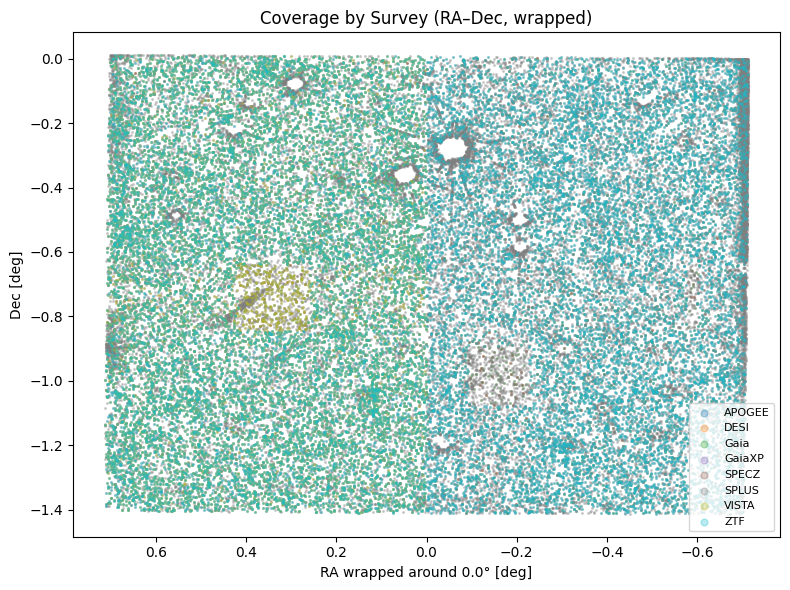

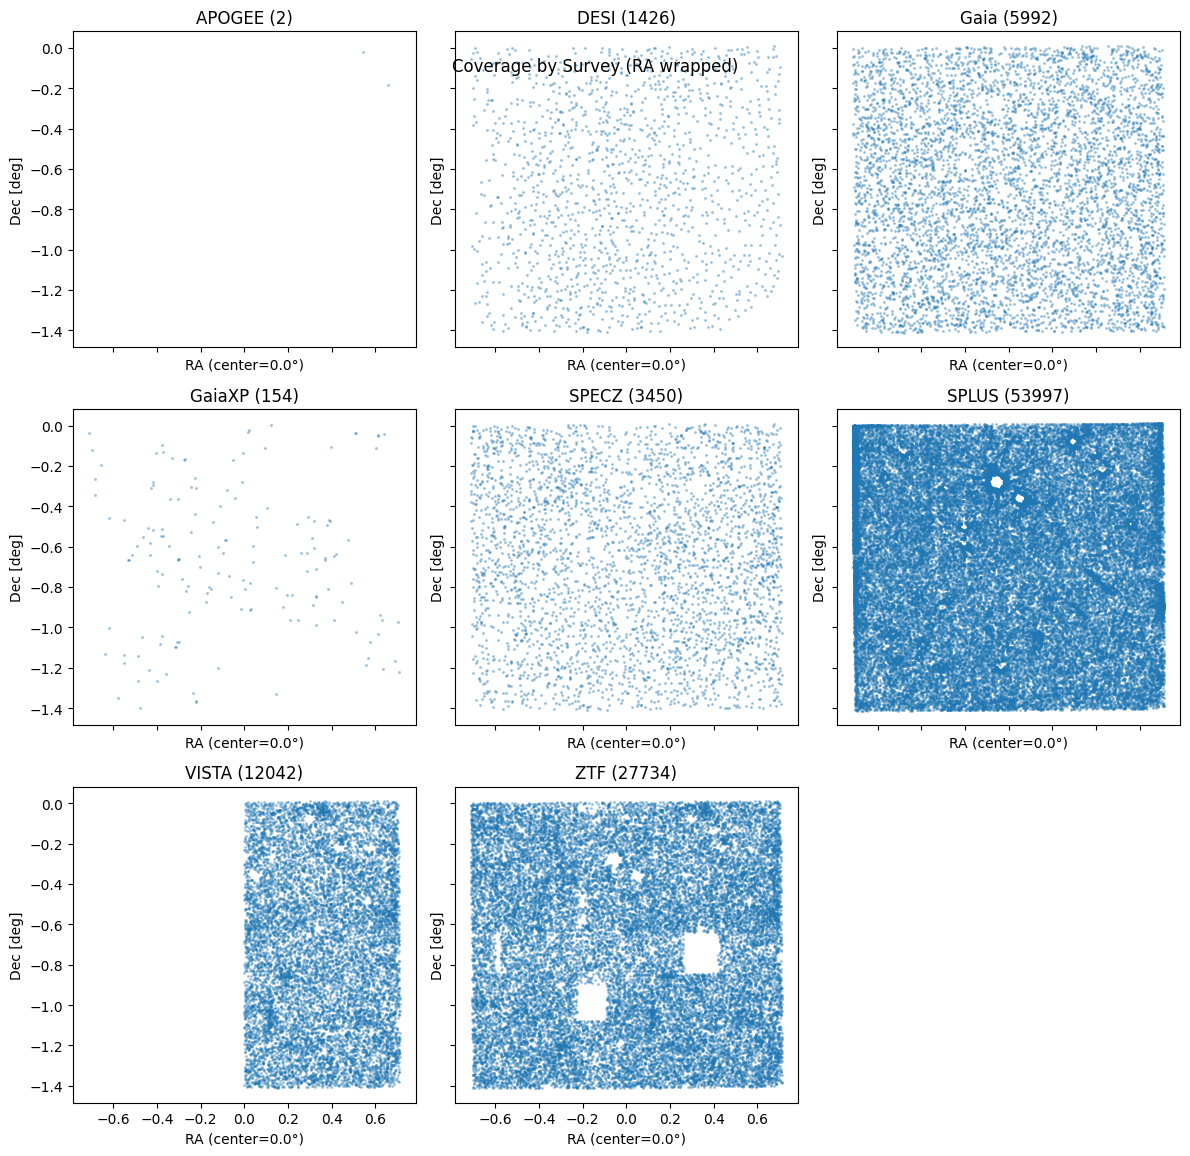

In [25]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------------------------
# Load datacubes
# -------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt

def wrap_ra(ra_deg, center=0.0):
    """
    Wrap RA around a chosen center so that the plot seam
    is away from the interesting region.

    center = 0.0  -> RA in [-180, +180]
    center = 180.0 -> RA in [0, 360] but shifted differently
    """
    ra = np.asarray(ra_deg, dtype=float)
    wrapped = (ra - center + 180.0) % 360.0 - 180.0 + center
    return wrapped

def load_datacubes(pattern="datacube_*.parquet", max_rows_per_file=None):
    """
    Load all datacube parquet files matching pattern into a single DataFrame.
    """
    files = sorted(glob.glob(pattern))
    if not files:
        raise FileNotFoundError(f"No files match pattern: {pattern}")

    dfs = []
    for f in files:
        print(f"[LOAD] {f}")
        df = pd.read_parquet(f)
        if max_rows_per_file is not None:
            df = df.iloc[:max_rows_per_file]
        dfs.append(df)

    all_df = pd.concat(dfs, ignore_index=True)
    print(f"[LOAD] Total rows loaded: {len(all_df)} from {len(files)} files")
    return all_df

# -------------------------------------------------
# Survey presence helpers
# -------------------------------------------------

def survey_masks(df, ra_col="ra", dec_col="dec"):
    """
    Build boolean masks indicating where each survey is present.

    Returns
    -------
    masks : dict
        {survey_name: boolean Series aligned with df.index}
    """

    # Base mask: where S-PLUS coordinates are valid
    base = df[ra_col].notna() & df[dec_col].notna()

    masks = {}

    # S-PLUS is the base catalog
    masks["SPLUS"] = base

    # GAIA: any Gaia row with a valid source_id (preferred) or RA/DEC
    if "gaia_source_id" in df.columns:
        masks["Gaia"] = base & df["gaia_source_id"].notna()
    elif {"gaia_ra", "gaia_dec"}.issubset(df.columns):
        masks["Gaia"] = base & df["gaia_ra"].notna() & df["gaia_dec"].notna()

    # Gaia XP
    if "gaiaxp_source_id" in df.columns:
        masks["GaiaXP"] = base & df["gaiaxp_source_id"].notna()

    # ZTF: require at least an objectid (we defined ztf_objectid when matching)
    ztf_cols = [c for c in df.columns if c.startswith("ztf_")]
    if "ztf_objectid" in df.columns:
        masks["ZTF"] = base & df["ztf_objectid"].notna()
    elif ztf_cols:
        # fallback: any non-null ZTF data
        masks["ZTF"] = base & (~df[ztf_cols].isna().all(axis=1))

    # DESI: presence if we have TARGET_RA
    if "desi_TARGET_RA" in df.columns:
        masks["DESI"] = base & df["desi_TARGET_RA"].notna()

    # APOGEE: presence if APOGEE RA exists
    if "apogee_RA" in df.columns:
        masks["APOGEE"] = base & df["apogee_RA"].notna()

    # spec-z: presence if specz RA exists
    if "specz_RA" in df.columns:
        masks["SPECZ"] = base & df["specz_RA"].notna()

    # VISTA: presence if we have vista_ra/vista_dec
    if "vista_ra" in df.columns:
        masks["VISTA"] = base & df["vista_ra"].notna()

    return masks

# -------------------------------------------------
# Plot coverage by survey
# -------------------------------------------------

def plot_survey_coverage(df,
                         ra_col="ra",
                         dec_col="dec",
                         use_survey_coords=False,
                         marker_size=2,
                         alpha=0.4,
                         ra_center=0.0):
    """
    Plot RA–Dec coverage for each survey.

    ra_center controls where the RA seam is placed:
      - ra_center = 0.0  -> RA in [-180, 180], seam at ±180 (good for regions near RA~0)
      - ra_center = 180.0 -> RA in [0, 360] wrapped around 180
    """
    masks = survey_masks(df, ra_col=ra_col, dec_col=dec_col)
    surveys = sorted(masks.keys())

    print("[PLOT] Surveys found:", surveys)

    plt.figure(figsize=(8, 6))
    cmap = plt.cm.get_cmap("tab10", len(surveys))

    for i, survey in enumerate(surveys):
        m = masks[survey]
        if not m.any():
            continue

        # Decide which RA/Dec columns to use
        if not use_survey_coords or survey == "SPLUS":
            ra = df.loc[m, ra_col].astype(float)
            dec = df.loc[m, dec_col].astype(float)
        else:
            if survey == "Gaia" and {"gaia_ra", "gaia_dec"}.issubset(df.columns):
                ra = df.loc[m, "gaia_ra"].astype(float)
                dec = df.loc[m, "gaia_dec"].astype(float)
            elif survey == "GaiaXP" and {"gaia_ra", "gaia_dec"}.issubset(df.columns):
                ra = df.loc[m, "gaia_ra"].astype(float)
                dec = df.loc[m, "gaia_dec"].astype(float)
            elif survey == "ZTF":
                if {"ztf_objra", "ztf_objdec"}.issubset(df.columns):
                    ra = df.loc[m, "ztf_objra"].astype(float)
                    dec = df.loc[m, "ztf_objdec"].astype(float)
                else:
                    ra = df.loc[m, ra_col].astype(float)
                    dec = df.loc[m, dec_col].astype(float)
            elif survey == "DESI" and {"desi_TARGET_RA", "desi_TARGET_DEC"}.issubset(df.columns):
                ra = df.loc[m, "desi_TARGET_RA"].astype(float)
                dec = df.loc[m, "desi_TARGET_DEC"].astype(float)
            elif survey == "APOGEE" and {"apogee_RA", "apogee_DEC"}.issubset(df.columns):
                ra = df.loc[m, "apogee_RA"].astype(float)
                dec = df.loc[m, "apogee_DEC"].astype(float)
            elif survey == "SPECZ" and {"specz_RA", "specz_DEC"}.issubset(df.columns):
                ra = df.loc[m, "specz_RA"].astype(float)
                dec = df.loc[m, "specz_DEC"].astype(float)
            elif survey == "VISTA" and {"vista_ra", "vista_dec"}.issubset(df.columns):
                ra = df.loc[m, "vista_ra"].astype(float)
                dec = df.loc[m, "vista_dec"].astype(float)
            else:
                ra = df.loc[m, ra_col].astype(float)
                dec = df.loc[m, dec_col].astype(float)

        # Wrap RA so 359° and 1° are neighbours in the plot
        ra_wrapped = wrap_ra(ra, center=ra_center)

        print(f"[PLOT] {survey}: {m.sum()} points")
        plt.scatter(
            ra_wrapped,
            dec,
            s=marker_size,
            alpha=alpha,
            label=survey,
            color=cmap(i),
        )

    plt.gca().invert_xaxis()  # RA increases to the left
    plt.xlabel(f"RA wrapped around {ra_center}° [deg]")
    plt.ylabel("Dec [deg]")
    plt.title("Coverage by Survey (RA–Dec, wrapped)")
    plt.legend(markerscale=4, fontsize=8, loc="best")
    plt.tight_layout()
    plt.show()

# -------------------------------------------------
# Optional: one panel per survey
# -------------------------------------------------

def plot_survey_coverage_panels(df,
                                ra_col="ra",
                                dec_col="dec",
                                use_survey_coords=False,
                                marker_size=2,
                                alpha=0.4,
                                ra_center=0.0):
    """
    One subplot per survey, RA–Dec coverage with RA wrapping.
    """
    masks = survey_masks(df, ra_col=ra_col, dec_col=dec_col)
    surveys = sorted(masks.keys())

    n = len(surveys)
    ncols = min(3, n)
    nrows = int(np.ceil(n / ncols))

    fig, axes = plt.subplots(nrows, ncols,
                             figsize=(4*ncols, 4*nrows),
                             sharex=True, sharey=True)
    axes = np.atleast_1d(axes).ravel()

    for ax, survey in zip(axes, surveys):
        m = masks[survey]
        if not m.any():
            ax.set_title(f"{survey} (0)")
            ax.axis("off")
            continue

        if not use_survey_coords or survey == "SPLUS":
            ra = df.loc[m, ra_col].astype(float)
            dec = df.loc[m, dec_col].astype(float)
        else:
            if survey == "Gaia" and {"gaia_ra", "gaia_dec"}.issubset(df.columns):
                ra = df.loc[m, "gaia_ra"].astype(float)
                dec = df.loc[m, "gaia_dec"].astype(float)
            elif survey == "GaiaXP" and {"gaia_ra", "gaia_dec"}.issubset(df.columns):
                ra = df.loc[m, "gaia_ra"].astype(float)
                dec = df.loc[m, "gaia_dec"].astype(float)
            elif survey == "ZTF" and {"ztf_objra", "ztf_objdec"}.issubset(df.columns):
                ra = df.loc[m, "ztf_objra"].astype(float)
                dec = df.loc[m, "ztf_objdec"].astype(float)
            elif survey == "DESI" and {"desi_TARGET_RA", "desi_TARGET_DEC"}.issubset(df.columns):
                ra = df.loc[m, "desi_TARGET_RA"].astype(float)
                dec = df.loc[m, "desi_TARGET_DEC"].astype(float)
            elif survey == "APOGEE" and {"apogee_RA", "apogee_DEC"}.issubset(df.columns):
                ra = df.loc[m, "apogee_RA"].astype(float)
                dec = df.loc[m, "apogee_DEC"].astype(float)
            elif survey == "SPECZ" and {"specz_RA", "specz_DEC"}.issubset(df.columns):
                ra = df.loc[m, "specz_RA"].astype(float)
                dec = df.loc[m, "specz_DEC"].astype(float)
            elif survey == "VISTA" and {"vista_ra", "vista_dec"}.issubset(df.columns):
                ra = df.loc[m, "vista_ra"].astype(float)
                dec = df.loc[m, "vista_dec"].astype(float)
            else:
                ra = df.loc[m, ra_col].astype(float)
                dec = df.loc[m, dec_col].astype(float)

        ra_wrapped = wrap_ra(ra, center=ra_center)

        ax.scatter(ra_wrapped, dec, s=marker_size, alpha=alpha)
        ax.invert_xaxis()
        ax.set_title(f"{survey} ({m.sum()})")
        ax.set_xlabel(f"RA (center={ra_center}°)")
        ax.set_ylabel("Dec [deg]")

    for ax in axes[len(surveys):]:
        ax.axis("off")

    fig.suptitle("Coverage by Survey (RA wrapped)", y=0.92)
    plt.tight_layout()
    plt.show()

# -------------------------------------------------
# Example usage
# -------------------------------------------------

if __name__ == "__main__":
    # Load your cube(s)
    df = load_datacubes("datacube_*.parquet", max_rows_per_file=None)

    # Quick overview: all surveys on one RA–Dec plot
    plot_survey_coverage(df,
                         ra_col="ra",
                         dec_col="dec",
                         use_survey_coords=False,
                         marker_size=1.5,
                         alpha=0.3)

    # Or, one panel per survey:
    plot_survey_coverage_panels(df,
                                ra_col="ra",
                                dec_col="dec",
                                use_survey_coords=False,
                                marker_size=1.5,
                                alpha=0.3)

In [27]:
df['ztf_filterid']

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
53992    1.0
53993    NaN
53994    2.0
53995    NaN
53996    2.0
Name: ztf_filterid, Length: 53997, dtype: float64

In [23]:
import pandas as pd

df = pd.read_parquet("datacube_STRIPE82-0001.parquet")

DataFrame provided: 53997 rows, 987 columns

=== Object at index 1995 ===
                                                                                       value
id                                                                        b'i06S820001001JF'
random_idx                                                                          82254129
ra                                                                                359.329287
dec                                                                                -1.384488
field                                                                       b'STRIPE82-0001'
a_pixel_det                                                                         4.083656
a_restricted_pixel_r                                                                4.083656
b_pixel_det                                                                         3.820027
b_restricted_pixel_r                                                                3.820

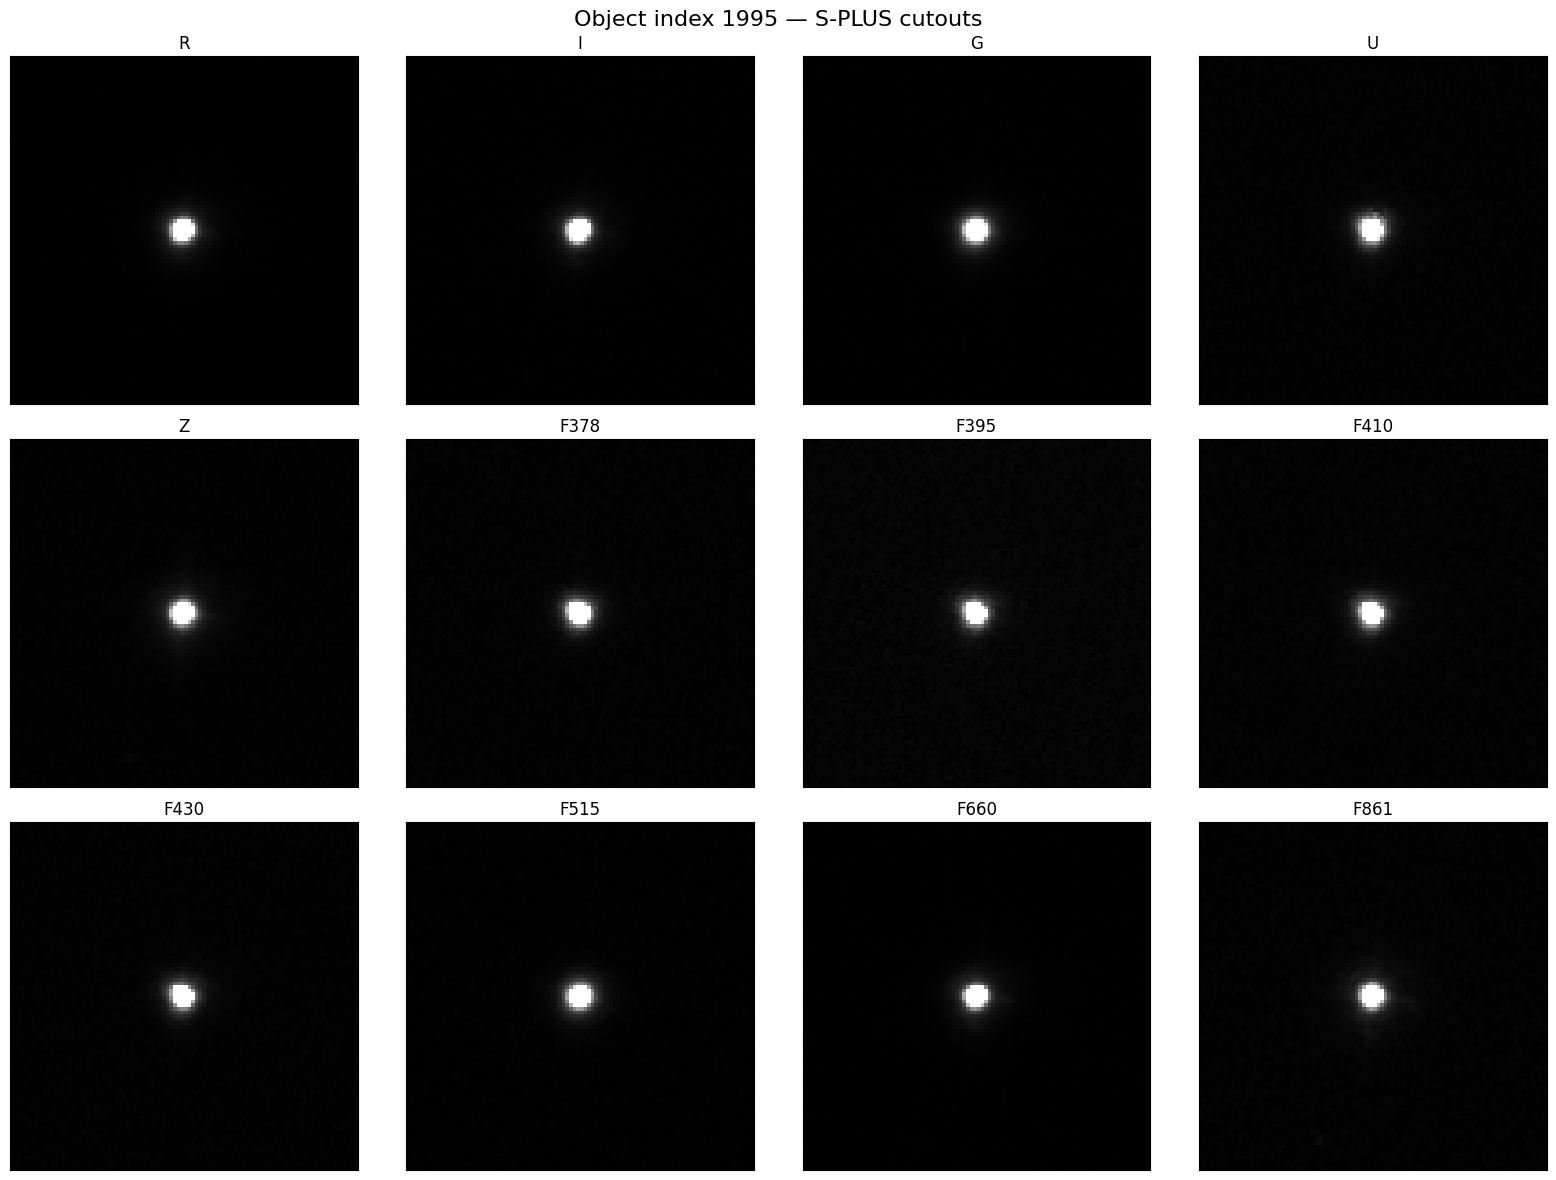

[SPECTRA] No wavelength column found; will use pixel index for x.
No array-like gaiaxp_* columns to plot as spectra.


,id,random_idx,ra,dec,field,a_pixel_det,a_restricted_pixel_r,b_pixel_det,b_restricted_pixel_r,class_star_det,...,vista_hapermag6,vista_hapermag6err,vista_ksapermag3,vista_ksapermag3err,vista_ksapermag4,vista_ksapermag4err,vista_ksapermag6,vista_ksapermag6err,vista_ra,vista_dec
0,b'i06S82000100000',78988955,359.326661,-1.412885,b'STRIPE82-0001',0.510947,0.510947,0.488726,0.488726,0.349743,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,b'i06S82000100001',87233933,359.331556,-1.412733,b'STRIPE82-0001',0.506796,0.506796,0.491438,0.491438,0.349869,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,b'i06S82000100002',116739303,359.549595,-1.412636,b'STRIPE82-0001',0.506652,0.506652,0.492518,0.492518,0.350482,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,b'i06S82000100003',90025356,359.305005,-1.412760,b'STRIPE82-0001',0.844294,0.844294,0.353997,0.353997,0.350129,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,b'i06S82000100004',40969914,359.352022,-1.412511,b'STRIPE82-0001',1.186475,1.186475,0.336744,0.336744,0.349256,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53992,b'i06S820001015NS',17622082,0.516515,-0.095967,b'STRIPE82-0001',2.039208,2.039208,1.738197,1.738197,0.000121,...,17.413664,0.101539,17.077509,0.060739,16.939114,0.065989,16.762222,0.100658,0.516493,-0.096081
53993,b'i06S820001015NT',103408444,0.297338,-0.095844,b'STRIPE82-0001',1.603435,1.603435,0.993441,0.993441,0.000250,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53994,b'i06S820001015NU',29188256,359.745180,-0.100063,b'STRIPE82-0001',1.566600,1.566600,1.243641,1.243641,0.000811,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53995,b'i06S820001015NV',142961355,359.916280,-0.089911,b'STRIPE82-0001',0.847641,0.847641,0.491313,0.491313,0.346794,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
# inspect row 42, using the existing df (no re-load)
inspect_object(df=df, idx=1995)

In [18]:
subset['ztf_filterid']

85       1.0
108      1.0
145      1.0
153      1.0
160      1.0
        ... 
53938    3.0
53952    3.0
53963    3.0
53978    2.0
53984    1.0
Name: ztf_filterid, Length: 4731, dtype: float64